## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import time
from itertools import chain
import sklearn.model_selection as skl
from random import sample 

import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix, classification_report

print('TensorFlow version =',tf.__version__)

TensorFlow version = 2.2.0


Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,data/images_001/images/00000001_002.png


In [4]:
# Parse unique labels from 'Finding Labels' feature
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print('Dataset distinct labels: \n', labels)

Dataset distinct labels: 
 ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [5]:
## create binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
df = all_xray_df.copy()
for disease in labels:
    df[disease] = df['Finding Labels'].map(lambda x: 1.0 if disease in x else 0)
print(df.shape)
df.head(5)

(112120, 28)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df = df.drop('Unnamed: 11', axis=1)

In [7]:
## create 'pneumonia_class' column that will allow us to look at 
## images with or without pneumonia for binary classification
df['pneumonia_class'] = df['Pneumonia'].apply(lambda x: 1.0 if x==1.0 else 0)
print(df.shape)
df.head(5)

(112120, 28)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [8]:

def create_splits(df, y_label, train_size=0.8, test_size=0.2, patient_id='Patient ID'):
    
    
    # write from scratch to ensure no patients cross both train and validation groups
    # First, get all records positive for disease label
    pos_group = df[df[y_label] == 1]
    print('pos_group size: ', pos_group.shape)

    # split to train and test groups (positive only)
    train = pos_group.sample(int(train_size * pos_group.shape[0]))
    print(f'pos_group train size: {train.shape}, {len(train)/len(pos_group): 0.4f}')
    # ensure no patients overlap groups
    val = pos_group[~pos_group[patient_id].isin(train[patient_id])]
    print(f'pos group val size: {val.shape}, {len(val)/len(pos_group): 0.4f}')
    print(f'utilized pos_group: {len(train)+len(val)}, {(len(train)+len(val))/len(pos_group): 0.4f}')
    print(f'lost pos_group (patient overlap): {len(pos_group)-(len(train)+len(val))}, {(len(pos_group)-len(train)-len(val))/len(pos_group): 0.4f}')
    # note: we lose about 8% of our pneumonia samples separating patients
    
    # second, verify that there are no patients in both groups
    train_patients = set(train[patient_id].unique())
    val_patients = set(val[patient_id].unique())
    print(f'patients in both train and test: {len(train_patients.intersection(val_patients))}')
    
    print(f'train/val unique patient length: {len(train_patients)}, {len(val_patients)}')
    
    print(f'% train patient set: {len(train_patients)/(len(train_patients)+len(val_patients)): 0.4f}')
    print(f'% val patient set: {len(val_patients)/(len(train_patients)+len(val_patients)): 0.4f}') # % percent of images
    print(f'% train_df: {len(train)/(len(train)+len(val)): 0.4f}')
    print(f'% val_df: {len(val)/(len(train)+len(val)): 0.4f}') # percent of patients
    
    # third, add negative cases (balance train 50:50, test 20:80 for positive to negative cases)
    neg_group = df[~df[patient_id].isin(pos_group[patient_id])]
    # print(neg_group.shape) 
    add_train = neg_group.sample(len(train))
    #print('pos/neg size: ', train.shape, add_train.shape)
    train_df = pd.concat([train, add_train])
    print('train_df shape: ', train_df.shape)
    
    # second half of conditional here is optionalTrue
    neg_group_not_train = df[~df[patient_id].isin(train_df[patient_id]) & ~df[patient_id].isin(val[patient_id])]
    #print('neg_group_not_train.shape: ', neg_group_not_train.shape)
    
    add_val = neg_group_not_train.sample(len(val)*4)
    #print('add_val.shape: ', add_val.shape)
    val_df = pd.concat([val, add_val])
    print('val_df shape: ', val_df.shape)

    return train_df, val_df


#### Split data accounting for EDA conclusions:

1. Dataset is relatively clean, however, there is erroneous 'Patient Age' data which should be cleaned.
2. We have 30,805 patients in our dataset, an average of about 3-4 images per patient. Actually, most patients have 0 or 1 follow-ups but may have many more. We should take the trouble to split the train/test datasets such that patients are either in the train or test dataset, but not both, to prevent data leakage based on any patient having multiple images.

In [9]:
train_pdf, val_pdf = create_splits(df[df['Patient Age']<100], 'pneumonia_class', train_size=0.80, test_size=0.20, patient_id='Patient ID')

pos_group size:  (1430, 28)
pos_group train size: (1144, 28),  0.8000
pos group val size: (162, 28),  0.1133
utilized pos_group: 1306,  0.9133
lost pos_group (patient overlap): 124,  0.0867
patients in both train and test: 0
train/val unique patient length: 847, 161
% train patient set:  0.8403
% val patient set:  0.1597
% train_df:  0.8760
% val_df:  0.1240
train_df shape:  (2288, 28)
val_df shape:  (810, 28)


In [10]:
def verify_splits(train_df, val_df, y_label):

    # verify 50/50 pos/neg train set for y_label 
    print('positive/negative label balance (train: 0.5): ', train_df[y_label].sum()/len(train_df))

    # verify 20/80 pos/neg val set for y_label 
    print('positive/negative label balance (val: 0.2): ', val_df[y_label].sum()/len(val_df))

    # final numbers
    print('train_df (pos length, total): ', len(train_df[train_df[y_label]==1]))
    print('val_df (pos length, total): ', len(val_df[val_df[y_label]==1]))
    print(f'% train_df, % val_df: {len(train_df)/(len(train_df)+len(val_df)): 0.4f}, {len(val_df)/(len(train_df)+len(val_df)): 0.4f}')

    print('train_df: ', len(train_df))
    print('val_df: ', len(val_df))
    print('total samples: ', len(train_df)+len(val_df))

In [11]:
verify_splits(train_pdf, val_pdf, 'pneumonia_class')

positive/negative label balance (train: 0.5):  0.5
positive/negative label balance (val: 0.2):  0.2
train_df (pos length, total):  1144
val_df (pos length, total):  162
% train_df, % val_df:  0.7385,  0.2615
train_df:  2288
val_df:  810
total samples:  3098


In [12]:
train_pdf['Patient Age'].describe()

count    2288.000000
mean       46.439685
std        16.862437
min         2.000000
25%        33.000000
50%        48.000000
75%        59.250000
max        90.000000
Name: Patient Age, dtype: float64

In [13]:
train_pdf.to_csv('train_path2.csv')
val_pdf.to_csv('val_path2.csv')

In [14]:
train_df = train_pdf.copy()
val_df = val_pdf.copy()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation(split):
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # training augmentation
    if split == 'train':
        print('creating ImageDataGenerator (train)')
        idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = False, 
                                  vertical_flip = False,
                                  brightness_range=[0.9,1.1],
                                  height_shift_range= 0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=5, 
                                  shear_range = 0.1,
                                  zoom_range=0.1)
    
    # validation augmentation requires rescaling only
    else:
        print('creating ImageDataGenerator (val)')
        idg = ImageDataGenerator(rescale=1. / 255.0)
    
    return idg


def make_train_gen(train_df, IMG_SIZE, BATCH_SIZE):
    
    ## Create the actual generators using the output of my_image_augmentation for training data    
    train_idg = my_image_augmentation('train')
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'raw',
                                                 target_size = IMG_SIZE, 
                                                 batch_size = BATCH_SIZE
                                             )
    
    return train_gen


def make_val_gen(val_df, IMG_SIZE, BATCH_SIZE):
    
    val_idg = my_image_augmentation('val')
    val_gen = val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'raw',
                                             target_size = IMG_SIZE, 
                                             batch_size = BATCH_SIZE
                                         ) 
    return val_gen



In [16]:
IMG_SIZE = (224,224)
BATCH_SIZE = 16

train_gen = make_train_gen(train_df, IMG_SIZE, 16)
val_gen = make_val_gen(val_df, IMG_SIZE, 128)

creating ImageDataGenerator (train)
Found 2288 validated image filenames.
creating ImageDataGenerator (val)
Found 810 validated image filenames.


In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

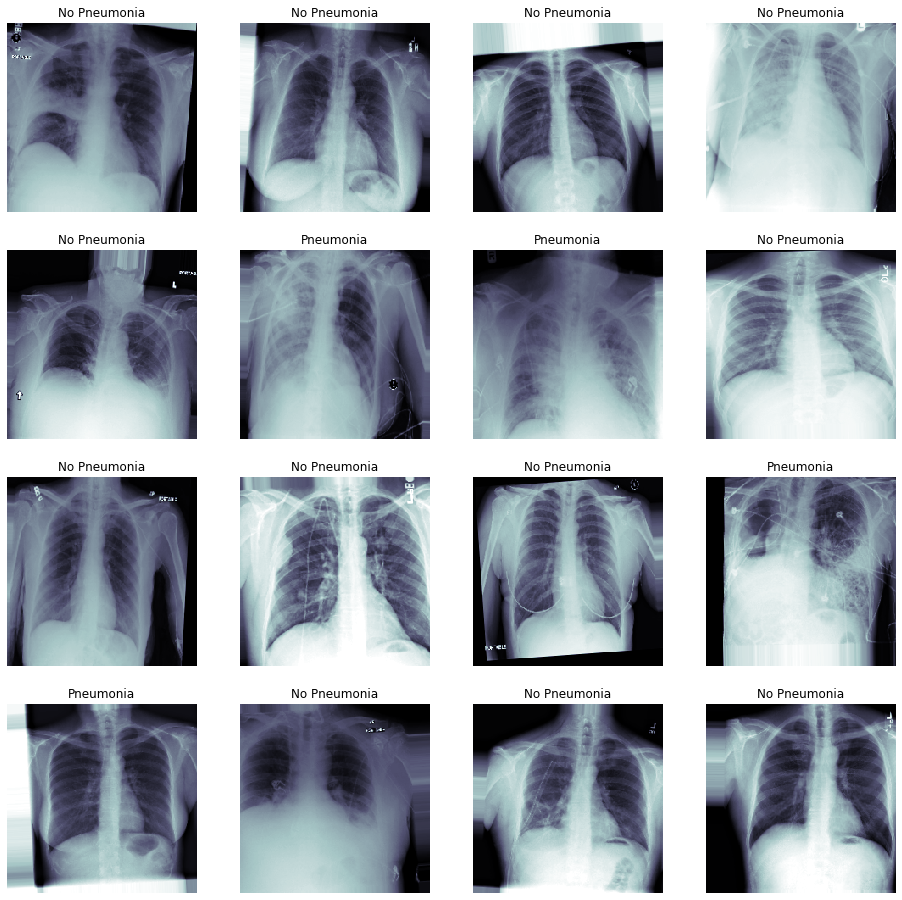

In [18]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')


## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [19]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # freeze first 17 layers (freeze all but the last layer) - no re-training (trainable false)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    # spot check trainability
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

    return vgg_model

In [20]:
# load vgg, confirm trainability layers
vgg_model = load_pretrained_model()

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [21]:
# view vgg model
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [22]:
def build_my_model(transfer_model):

    new_model = Sequential()
    # Add the convolutional part of the VGG16 model from above (pre-trained model)
    new_model.add(transfer_model)
    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    new_model.add(Flatten())
    
    # Fine-Tuning
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.4))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # continue 
    new_model.add(Dropout(0.4))
    new_model.add(Dense(256, activation='relu'))

    # Add final dense (aka. fully-connected) layer 
    new_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, learning rate, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    # run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(loss = "...", optimizer = "...", metrics = "..", options = run_opts)
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [23]:
model = build_my_model(vgg_model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [24]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class_7')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [25]:
t0 = time.time()
## train your model
history = model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 50, 
                           callbacks = callbacks_list)
t1 = time.time()
print(f'time elapsed: {(t1-t0):.9}')

Epoch 1/50
143/143 [==============================] - 42s 292ms/step - loss: 0.7139 - binary_accuracy: 0.5717 - val_loss: 0.6743 - val_binary_accuracy: 0.6094

Epoch 00001: val_loss improved from inf to 0.67429, saving model to xray_class_7_my_model.best.hdf5
Epoch 2/50
143/143 [==============================] - 41s 288ms/step - loss: 0.6577 - binary_accuracy: 0.6132 - val_loss: 0.6676 - val_binary_accuracy: 0.6016

Epoch 00002: val_loss improved from 0.67429 to 0.66759, saving model to xray_class_7_my_model.best.hdf5
Epoch 3/50
143/143 [==============================] - 41s 286ms/step - loss: 0.6391 - binary_accuracy: 0.6425 - val_loss: 0.6127 - val_binary_accuracy: 0.6406

Epoch 00003: val_loss improved from 0.66759 to 0.61272, saving model to xray_class_7_my_model.best.hdf5
Epoch 4/50
143/143 [==============================] - 39s 273ms/step - loss: 0.6306 - binary_accuracy: 0.6512 - val_loss: 0.6482 - val_binary_accuracy: 0.6562

Epoch 00004: val_loss did not improve from 0.61272
E

Metrics:  dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


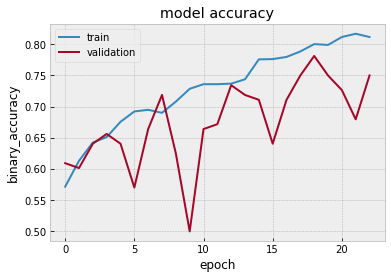

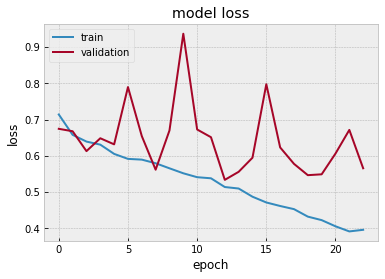

In [26]:
# show individual metrics
print('Metrics: ', history.history.keys())
plt.figure()
plt.style.use('bmh')
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.figure()
plt.style.use("bmh")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
# show aggregrate metrics
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("bmh")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")
    

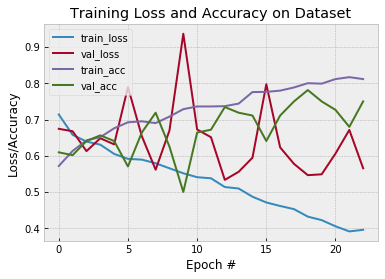

In [28]:
plot_history(history)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [29]:
model.save_weights(weight_path)
model.save('model_512_7.hdf5')

In [30]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 8, verbose = False)

In [31]:
def plot_auc(t_y, p_y):
    plt.style.use("bmh")
    fig, c_ax = plt.subplots(1,1, figsize = (7,7))
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.set_title('ROC Curve')
    
def plot_precision_recall_curve(t_y, p_y):
    plt.style.use("bmh")
    fig, c_ax = plt.subplots(1,1, figsize = (7,7))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    c_ax.set_title('Precision-Recall Curve')
    
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
def plot_f1_thresholds(t_y, p_y):
    plt.style.use("bmh")
    fig, c_ax = plt.subplots(1,1, figsize = (7,7))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    #print('thresholds:', len(thresholds), thresholds)
    f1 = calc_f1(precision, recall)   
    #print('f1:', len(f1), f1)
    c_ax.plot(thresholds,f1[0:len(thresholds)],label = 'F1_score per Threshold')
    c_ax.legend()
    c_ax.set_xlabel('Thresholds')
    c_ax.set_ylabel('F1_score')
    c_ax.set_title('F1 Score per Threshold')
    
def plot_distinct_precision_recall(t_y, p_y):
    plt.style.use("bmh")
    fig, c_ax = plt.subplots(1,1, figsize = (7,7))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    #print('thresholds:', len(thresholds), thresholds)
    f1 = calc_f1(precision, recall)   
    #print('f1:', len(f1), f1)
    c_ax.plot(thresholds, precision[:-1], label='precision')
    c_ax.plot(thresholds, recall[:-1], label='recall')
    c_ax.legend()
    c_ax.set_xlabel('Thresholds')
    c_ax.set_ylabel('Precision / Recall')
    c_ax.set_title('Precision/Recall per Threshold')

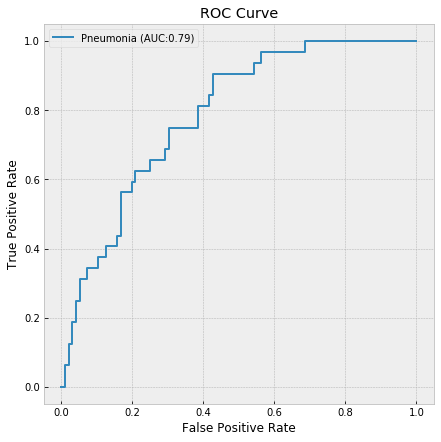

In [32]:
plot_auc(valY,pred_Y)

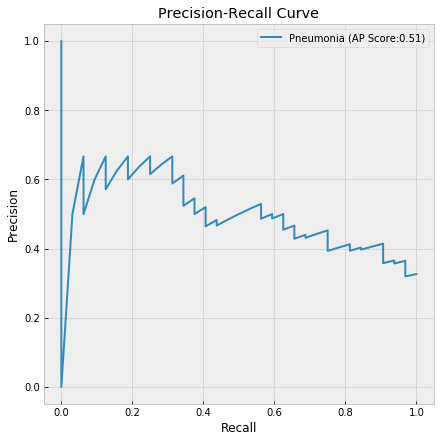

In [33]:
plot_precision_recall_curve(valY,pred_Y)

/home/magellan/anaconda3/envs/py37_aih/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


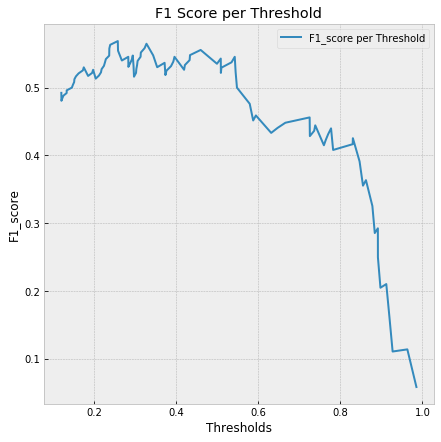

In [34]:
plot_f1_thresholds(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [35]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Find max F1 score w/ respective precision, recall, and thresholds
print('Metrics at maximum F1 Score: \n')
precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)

#print('f1_scores: ', f1_scores)
idx = np.argmax(f1_scores)
#print('idx: ', idx)
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(f1_scores[idx]), '\n')

model_threshold = thresholds[idx]
print('Our best threshold is: ', model_threshold)

Metrics at maximum F1 Score: 

Precision is: 0.4084507042253521
Recall is: 0.90625
Threshold is: 0.23956428
F1 Score is: 0.5686274509803921 

Our best threshold is:  0.23956428


/home/magellan/anaconda3/envs/py37_aih/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


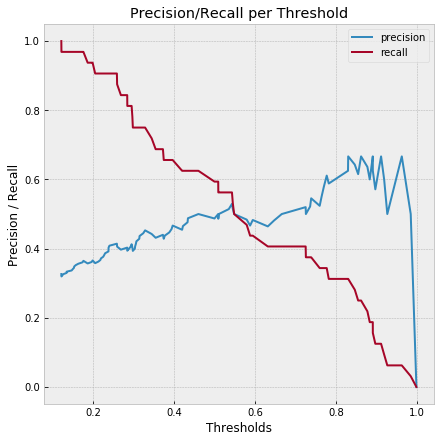

In [36]:
plot_distinct_precision_recall(valY, pred_Y)

In [37]:
# View thresholds at desired precision/recall level for curiosity
level = 0.8

print('Precision-Recall Trade-off at Level: 0.8 \n')

print('Recall value: ', level)
recall_value = level
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: ' + str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is:  ' + str(calc_f1(precision[idx],recall[idx])), '\n')

print('Precision value: ', level)
precision_value = level
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))


Precision-Recall Trade-off at Level: 0.8 

Recall value:  0.8
Precision is: 0.3939393939393939
Recall is: 0.8125
Threshold is: 0.28388718
F1 Score is:  0.5306122448979591 

Precision value:  0.8
Precision is: 0.6666666666666666
Recall is: 0.3125
Threshold is: 0.83078843
F1 Score is: 0.425531914893617


In [38]:
# show confusion_matrix for batch 1
tn, fp, fn, tp = confusion_matrix(valY, pred_Y > model_threshold).ravel()
print('Metrics for initial batch of test predictions: \n')
print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

sensitivity = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(tn+fp)

print('sensitivity :', sensitivity)
print('precision :', precision)
print('specificity :', specificity)

Metrics for initial batch of test predictions: 

tn: 55 fp: 41 fn: 3 tp: 29
sensitivity : 0.90625
precision : 0.4142857142857143
specificity : 0.5729166666666666


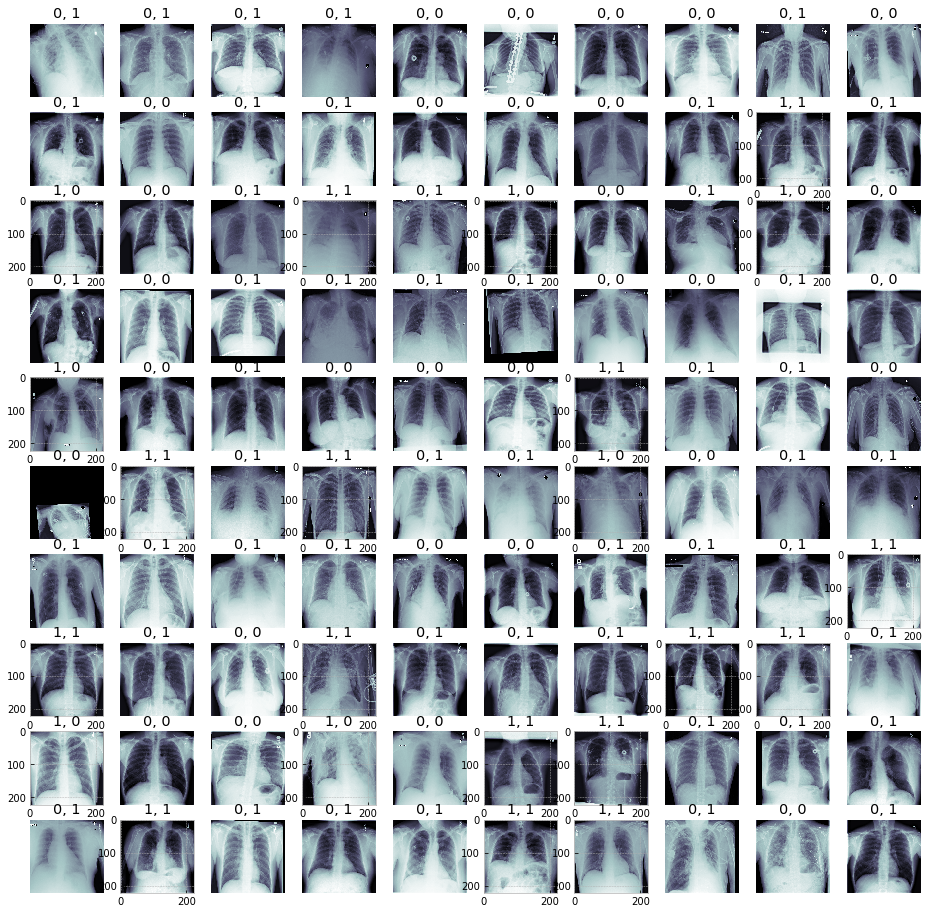

In [39]:
## Let's look at some examples of predicted v. true with our best model: 
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            if pred_Y[i] > model_threshold:
                c_ax.set_title('1, 1')
            else:
                c_ax.set_title('1, 0')
        else:
            if pred_Y[i] > model_threshold: 
                c_ax.set_title('0, 1')
            else:
                c_ax.set_title('0, 0')
            c_ax.axis('off')
            i=i+1

In [40]:
## Just save model architecture to a .json:
model_json = model.to_json()
with open("model_512_7.json", "w") as json_file:
    json_file.write(model_json)

#### Get stats for validation set

In [41]:
from skimage.transform import resize
def preprocess_image(img,img_size=(1,224,224,3)):
    img = img/255.0
    img_mean = np.mean(img)
    img_std = np.std(img)
    
    new_img = img.copy()
    new_img = (new_img - img_mean)/img_std
    new_img = resize(new_img, img_size)
    #print(new_img.shape)
    return new_img

In [42]:
df = val_df.copy()

In [43]:
df['proc_img'] = df['path'].apply(lambda x: preprocess_image(io.imread(x),img_size=(1,224,224,3)))

In [44]:
df.to_pickle("./val_proc_img_mod7.pkl")

In [45]:
df['raw_pred'] = df['proc_img'].apply(lambda x: model.predict(x))

In [46]:
df['pred'] = df['raw_pred'].apply(lambda x: 1.0 if x > model_threshold else 0.0)

In [47]:
df.to_pickle("./val_pred_mod7.pkl")

In [48]:
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,proc_img,raw_pred,pred
49126,00012464_001.png,No Finding,1,12464,43,M,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[[[-0.82875908 -0.82875908 -0.82875908], [-0....",[[0.9293159]],1.0
52435,00013239_000.png,No Finding,0,13239,63,M,PA,2992,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[[[0.02610505 0.02610505 0.02610505], [0.0261...",[[0.8193964]],1.0
71200,00017549_002.png,Atelectasis|Infiltration|Pneumonia,2,17549,31,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,"[[[[-1.00196506 -1.00196506 -1.00196506], [-1....",[[0.8461088]],1.0


In [49]:
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [50]:
for i in labels:
    y_test = df[df[i]==1]['pneumonia_class']
    y_pred = df[df[i]==1]['pred']
    #print(len(y_test), len(y_pred))
    tn, fp, fn, tp = confusion_matrix(
        y_test.values,
        y_pred.values, labels=[0.0,1.0]).ravel()
    
    sensitivity = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)

    print(f'{i}: {len(y_test)} samples')
    print('sensitivity :', sensitivity)
    print('precision :', precision)
    print('specificity :', specificity)
    print('\n')

Atelectasis: 100 samples
sensitivity : 1.0
precision : 0.43
specificity : 0.0


Cardiomegaly: 18 samples
sensitivity : 1.0
precision : 0.1111111111111111
specificity : 0.0


Consolidation: 28 samples
sensitivity : 1.0
precision : 0.39285714285714285
specificity : 0.0


Edema: 36 samples
sensitivity : 1.0
precision : 0.8611111111111112
specificity : 0.0


Effusion: 103 samples
sensitivity : 1.0
precision : 0.2524271844660194
specificity : 0.0


Emphysema: 9 samples
sensitivity : 1.0
precision : 0.1111111111111111
specificity : 0.0


Fibrosis: 13 samples
sensitivity : 1.0
precision : 0.15384615384615385
specificity : 0.0


Hernia: 2 samples
sensitivity : nan
precision : 0.0
specificity : 0.0


Infiltration: 166 samples
sensitivity : 1.0
precision : 0.40963855421686746
specificity : 0.0


Mass: 51 samples
sensitivity : 1.0
precision : 0.3333333333333333
specificity : 0.0


No Finding: 375 samples
sensitivity : nan
precision : 0.0
specificity : 0.0026666666666666666


Nodule: 49 samples
se

/home/magellan/anaconda3/envs/py37_aih/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/home/magellan/anaconda3/envs/py37_aih/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
